# PREDICCIÓN DEL PRECIOS DE ACTIVOS FINANCIEROS EMPLEANDO APRENDIZAJE AUTOMÁTICO
#### Autor: Samuel Valer Nasta

# Librerías empleadas

In [17]:
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns   
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, get_scorer_names
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasRegressor

# Preparación de los datos

Definimos las fechas de inicio y fin de train y test

In [18]:
fecha_inicio_train = '2010-01-01'
fecha_fin_train = '2023-01-01'
fecha_inicio_test = '2023-01-02'
fecha_fin_test = '2023-05-01'

Obtenemos los datos de train

In [19]:
datos_tesla = yf.download('TSLA', start=fecha_inicio_train, end=fecha_fin_train)
datos_sp500 = yf.download('^GSPC', start=fecha_inicio_train, end=fecha_fin_train)
datos_bitcoin = yf.download('BTC-USD', start=fecha_inicio_train, end=fecha_fin_train)
datos_petroleo = yf.download('CL=F', start=fecha_inicio_train, end=fecha_fin_train)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Creamos un dataframe nuevo con solo el precio de cierre.

In [20]:
datos_tesla = datos_tesla.loc[:,'Adj Close'].copy() 
datos_sp500 = datos_sp500.loc[:,'Adj Close'].copy()
datos_bitcoin = datos_bitcoin.loc[:,'Adj Close'].copy()
datos_petroleo = datos_petroleo.loc[:,'Adj Close'].copy()

Normalizamos / escalamos las variables para que tomen valor entre 0 y 1

In [21]:
scaler_tesla =  MinMaxScaler(feature_range=(0,1))
scaler_sp500 =  MinMaxScaler(feature_range=(0,1))
scaler_bitcoin =  MinMaxScaler(feature_range=(0,1))
scaler_petroleo =  MinMaxScaler(feature_range=(0,1))

datos_tesla = scaler_tesla.fit_transform(np.array(datos_tesla).reshape(-1,1))
datos_sp500 = scaler_sp500.fit_transform(np.array(datos_sp500).reshape(-1,1))
datos_bitcoin = scaler_bitcoin.fit_transform(np.array(datos_bitcoin).reshape(-1,1))
datos_petroleo = scaler_petroleo.fit_transform(np.array(datos_petroleo).reshape(-1,1))

print(datos_tesla.shape,
      datos_sp500.shape,
      datos_bitcoin.shape,
      datos_petroleo.shape)

(3150, 1) (3272, 1) (3028, 1) (3272, 1)


Definimos una función para crear datos de train y test

In [22]:
def create_time_series_dataset(data, time_steps):
    """
    Crea un conjunto de datos de series temporales para el entrenamiento de modelos de aprendizaje supervisado.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.

    Retorna:
        tuple: Una tupla que contiene dos arreglos numpy. El primer arreglo contiene las etiquetas de salida (y) y el segundo arreglo contiene las ventanas de tiempo de entrada (X).
    """

    X = []
    y = []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])    # Se crea una ventana de tiempo de longitud time_steps en la serie temporal de entrada
        y.append(data[i+time_steps])      # Se obtiene la etiqueta de salida correspondiente a la ventana de tiempo
    return np.array(y), np.array(X)      # Se devuelven las etiquetas de salida y las ventanas de tiempo de entrada como arreglos numpy en una tupla



Creamos los dataset, los dividimos en train y test luego los escalamos:

In [23]:
def preparar_datos_entrenamiento(datos, pasos):
    """
    Prepara los datos de entrenamiento para modelos de series temporales.

    Parámetros:
        - datos (array-like): Serie temporal de entrada.
        - pasos (int): Número de pasos de tiempo en cada ventana de tiempo.

    Retorna:
        tuple: Una tupla que contiene cuatro arreglos numpy. Los primeros dos arreglos contienen las etiquetas de salida (y) y las ventanas de tiempo de entrada (X) respectivamente. Los otros dos arreglos contienen las ventanas de tiempo de entrada remodeladas (X_reg) para su uso en modelos que requieren datos en 2D.
    """

    y, X = create_time_series_dataset(datos, pasos)                    # Se crea el conjunto de datos de series temporales
    indices_barajados = np.random.permutation(len(y))                  # Se barajan los índices de las muestras
    X_train, y_train = X[indices_barajados], y[indices_barajados]      # Se obtienen las ventanas de tiempo y etiquetas de salida barajadas

    X_train_reg = X_train.reshape(X_train.shape[0], -1)                # Se remodelan las ventanas de tiempo para su uso en modelos que requieren datos en 2D

    return X_train, y_train, X_train_reg, y_train

Descagramos datos nuevos (test) para gráficar y hacer pruebas.

In [24]:
datos_tesla_test = yf.download('TSLA', start=fecha_inicio_test, end=fecha_fin_test)
datos_sp500_test = yf.download('^GSPC', start=fecha_inicio_test, end=fecha_fin_test)
datos_bitcoin_test = yf.download('BTC-USD', start=fecha_inicio_test, end=fecha_fin_test) 
datos_petroleo_test = yf.download('CL=F', start=fecha_inicio_test, end=fecha_fin_test)

datos_tesla_test = datos_tesla_test.loc[:,'Adj Close'].copy() # todo ajustado
datos_sp500_test = datos_sp500_test.loc[:,'Adj Close'].copy()
datos_bitcoin_test = datos_bitcoin_test.loc[:,'Adj Close'].copy()
datos_petroleo_test = datos_petroleo_test.loc[:,'Adj Close'].copy()

datos_tesla_test = scaler_tesla.transform(np.array(datos_tesla_test).reshape(-1,1))
datos_sp500_test = scaler_sp500.transform(np.array(datos_sp500_test).reshape(-1,1))
datos_bitcoin_test = scaler_bitcoin.transform(np.array(datos_bitcoin_test).reshape(-1,1))
datos_petroleo_test = scaler_petroleo.transform(np.array(datos_petroleo_test).reshape(-1,1))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Modelos de aprendizaje automático

Usaremos las sigueintes métricas para evaluar los modelos:
   * RMSE (raíz del error cuadrático medio): esta métrica es útil para evaluar la precisión de la predicción del modelo en la misma escala que los valores de la variable objetivo.

   * MSE (error cuadrático medio): al igual que el RMSE, el MSE mide la precisión de la predicción del modelo. Sin embargo, como los errores están al cuadrado, el MSE puede dar más peso a los errores grandes.

   * MAE (error absoluto medio): esta métrica es una buena opción para evaluar la precisión de la predicción en una escala fácil de interpretar. El MAE es la media de las diferencias absolutas entre las predicciones y los valores reales.

   * R2 SCORE (coeficiente de determinación): esta métrica mide la proporción de la varianza en los valores de la variable objetivo que se explica por el modelo. Es una medida útil para evaluar el ajuste del modelo en general.


### Evaluación de los modelos

In [25]:
def evaluate_model(y_pred, y_test, name, ax, scaler):
    """
    Evalúa y visualiza el rendimiento de un modelo de predicción en series temporales.

    Parámetros:
        - y_pred (array-like): Predicciones del modelo.
        - y_test (array-like): Valores verdaderos de la serie temporal.
        - name (str): Nombre del modelo para mostrar en la salida y en la gráfica.
        - ax (matplotlib Axes): Ejes de la gráfica en la que se mostrarán los resultados.

    Retorna:
        None
    """
    
    # Transformar las predicciones y los valores verdaderos a su escala original
    original_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calcular métricas de evaluación del modelo
    rmse = np.sqrt(mean_squared_error(original_y_pred, original_y_test))
    mse = mean_squared_error(original_y_pred, original_y_test)
    mae = mean_absolute_error(original_y_pred, original_y_test)
    r2 = r2_score(original_y_pred, original_y_test)

    # Mostrar las métricas de evaluación en la salida
    print(name)
    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R²: ", r2)
    print('\n')
    
    # Graficar las predicciones y los valores verdaderos en la gráfica
    ax.plot(original_y_pred[1:31], label=name, color='red')
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.plot(original_y_test[0:30], label=name, color='blue')
    ax.set_title(name)

### Funciones para las predicciones continuas

In [26]:
def evaluate_model_seguidos(y_pred, y_test, name, ax, scaler):
    """
    Evalúa y visualiza el rendimiento de un modelo de predicción en series temporales para predicciones continuas.

    Parámetros:
        - y_pred (array-like): Predicciones del modelo.
        - y_test (array-like): Valores verdaderos de la serie temporal.
        - name (str): Nombre del modelo para mostrar en la salida y en la gráfica.
        - ax (matplotlib Axes): Ejes de la gráfica en la que se mostrarán los resultados.
        - dias (int): Número de días a mostrar en la gráfica.

    Retorna:
        None
    """
    
    # Transformar las predicciones y los valores verdaderos a su escala original
    original_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calcular métricas de evaluación del modelo
    rmse = np.sqrt(mean_squared_error(original_y_pred, original_y_test))
    mse = mean_squared_error(original_y_pred, original_y_test)
    mae = mean_absolute_error(original_y_pred, original_y_test)
    r2 = r2_score(original_y_pred, original_y_test)

    # Mostrar las métricas de evaluación en la salida
    print(name)
    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R²: ", r2)
    print('\n')
    
    # Graficar las predicciones y los valores verdaderos en la gráfica
    ax.plot(original_y_pred[1:11], label=name, color='red')
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.plot(original_y_test[0:10], label=name, color='blue')
    ax.set_title(name)

In [27]:
def predict_n_days(data, time_steps, dias, model):
    """
    Realiza predicciones para un número específico de días en una serie temporal utilizando un modelo de aprendizaje supervisado.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.
        - dias (int): Número de días para los que se realizarán predicciones.
        - model (objeto modelo): Modelo de aprendizaje supervisado previamente entrenado.

    Retorna:
        array: Arreglo numpy que contiene las predicciones para los días especificados.
    """

    y = []
    for i in range(dias):
        X = data[i:i+time_steps]            # Se extrae la ventana de tiempo de la serie temporal
        aux = X.reshape(-1, 1).T           # Se ajusta la forma de las características de entrada según el modelo
        y_pred = model.predict(aux)        # Se realiza la predicción utilizando el modelo
        data = np.append(data, y_pred)      # Se agrega la predicción al final de la serie temporal
        y.append(y_pred)                   # Se agrega la predicción al arreglo de predicciones
        
    return np.array(y)                     # Se devuelve el arreglo de predicciones como un arreglo numpy

In [28]:
def predict_n_days_red(data, time_steps, dias, model):
    """
    Realiza predicciones para un número específico de días en una serie temporal utilizando redes neuronales.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.
        - dias (int): Número de días para los que se realizarán predicciones.
        - model (objeto modelo): Modelo de aprendizaje supervisado previamente entrenado.

    Retorna:
        array: Arreglo numpy que contiene las predicciones para los días especificados.
    """

    y = []
    for i in range(dias):
        X = data[i:i+time_steps]            # Se extrae la ventana de tiempo de la serie temporal
        X = X.reshape(X.shape[1], X.shape[0] , 1)
        y_pred = model.predict(X, verbose=False)        # Se realiza la predicción utilizando el modelo
        data = np.append(data, y_pred)      # Se agrega la predicción al final de la serie temporal
        data = data.reshape(-1, 1)

        y.append(y_pred)                   # Se agrega la predicción al arreglo de predicciones
        
    return np.array(y)                     # Se devuelve el arreglo de predicciones como un arreglo numpy

## Regresión Lineal

### Preparación de datos

In [29]:
pasos = 2 # Número de pasos de tiempo en cada ventana
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos)

# Preparar datos de entrenamiento para Tesla
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos)

# Preparar datos de entrenamiento para S&P 500
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos)

# Preparar datos de entrenamiento para bitcoin
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos)

# Preparar datos de entrenamiento para petróleo
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos)

y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos)
x_tesla_t_reg = x_tesla_t.reshape(x_tesla_t.shape[0], -1)

y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos)
x_sp500_t_reg = x_sp500_t.reshape(x_sp500_t.shape[0], -1)

y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos)
x_bitcoin_t_reg = x_bitcoin_t.reshape(x_bitcoin_t.shape[0], -1)

y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos)
x_petroleo_t_reg = x_petroleo_t.reshape(x_petroleo_t.shape[0], -1)

### Entrenamiento

In [30]:
model_lr_tesla = LinearRegression()
model_lr_tesla.fit(x_train_tesla_reg, y_train_tesla)

model_lr_sp500 = LinearRegression()
model_lr_sp500.fit(x_train_sp500_reg, y_train_sp500)

model_lr_bitcoin = LinearRegression()
model_lr_bitcoin.fit(x_train_bitcoin_reg, y_train_bitcoin)

model_lr_petroleo = LinearRegression()
model_lr_petroleo.fit(x_train_petroleo_reg, y_train_petroleo)


LinearRegression()

### Comparación entre el precio predicho y el precio de cierre ajustado real (día siguiente)

Tesla (TSLA)
RMSE:  6.8675974488147284
MSE:  47.16389471896657
MAE:  5.336649168553215
R²:  0.9367492593673774


SP500 (^GSPC)
RMSE:  40.01399734922269
MSE:  1601.1199838636005
MAE:  32.065797628214035
R²:  0.7985661552675262


Bitcoin (BTC-USD)
RMSE:  667.0926205570604
MSE:  445012.56440168613
MAE:  465.08774492162655
R²:  0.9661091008004588


Petroleo (CL=F)
RMSE:  1.6312704198396695
MSE:  2.661043182643892
MAE:  1.292884897761752
R²:  0.8077290227013564




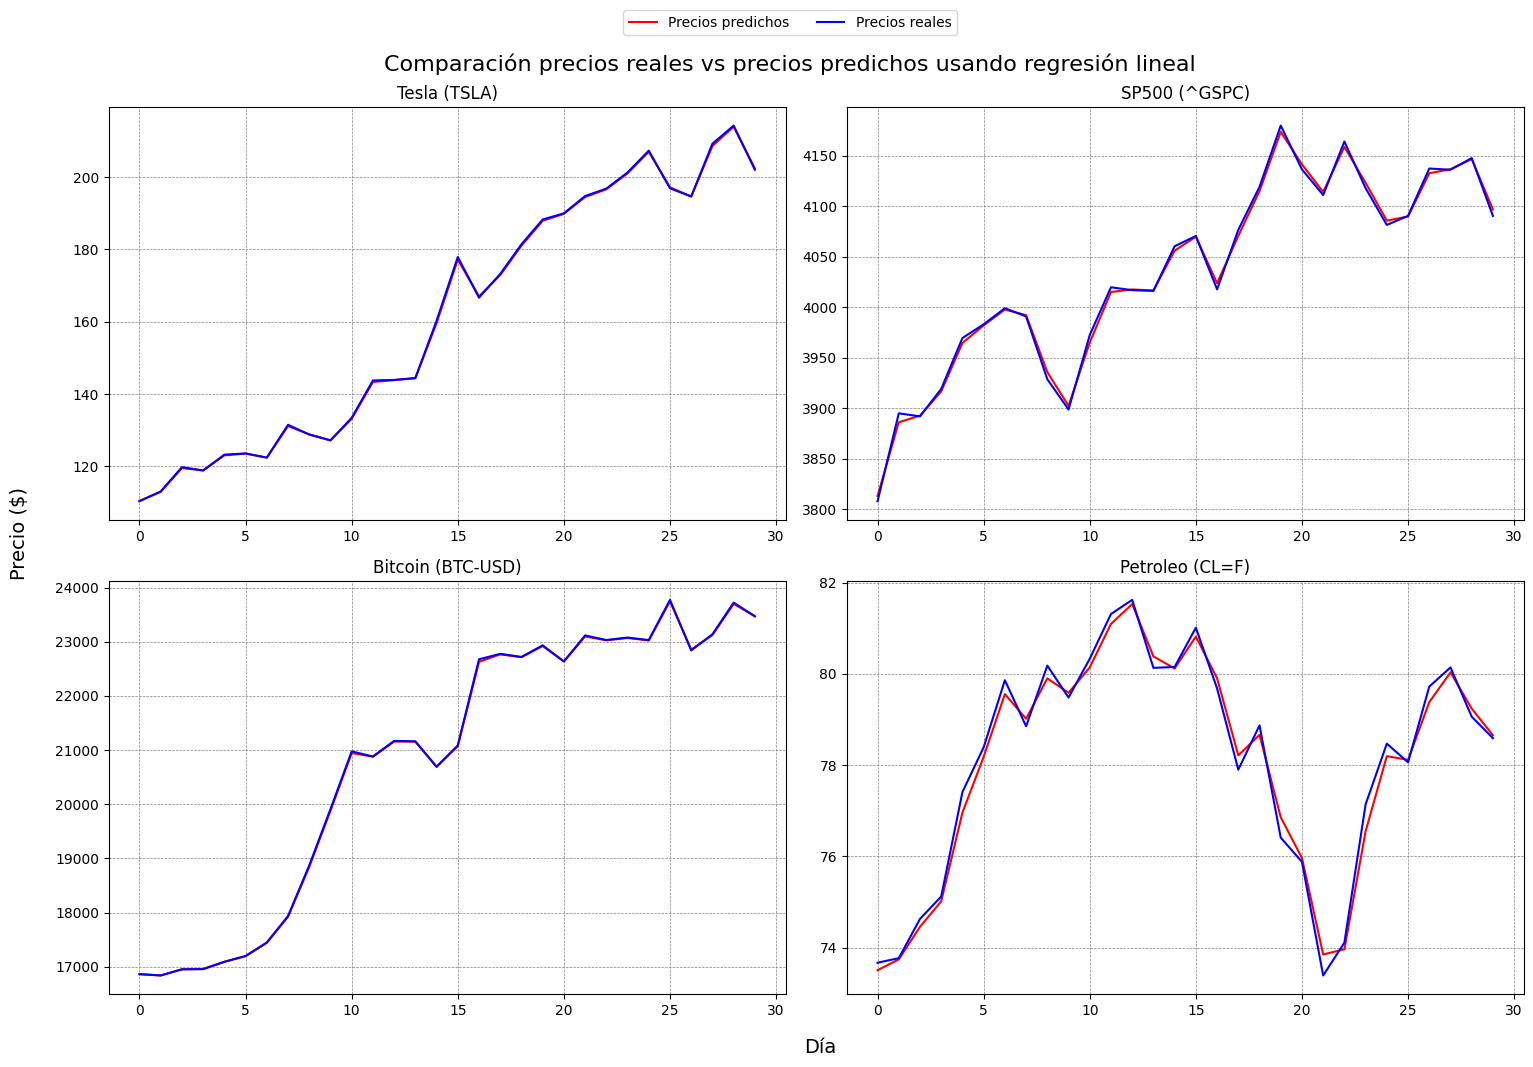

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = model_lr_tesla.predict(x_tesla_t_reg)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = model_lr_sp500.predict(x_sp500_t_reg)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = model_lr_bitcoin.predict(x_bitcoin_t_reg) 
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = model_lr_petroleo.predict(x_petroleo_t_reg)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()


### Predicción de los siguientes 15 días

Tesla (TSLA)
RMSE:  14.317827091301645
MSE:  205.00017261641133
MAE:  11.87675686619025
R²:  -84414.03887227786


SP500 (^GSPC)
RMSE:  104.02309427865326
MSE:  10820.804143305586
MAE:  94.08601046609283
R²:  -5650.794866806454


Bitcoin (BTC-USD)
RMSE:  2119.8067662663434
MSE:  4493580.726308572
MAE:  1475.3195391537085
R²:  -1030425.3736462401


Petroleo (CL=F)
RMSE:  5.059137453312378
MSE:  25.594871771508053
MAE:  4.295227212033695
R²:  -10987.216352231784




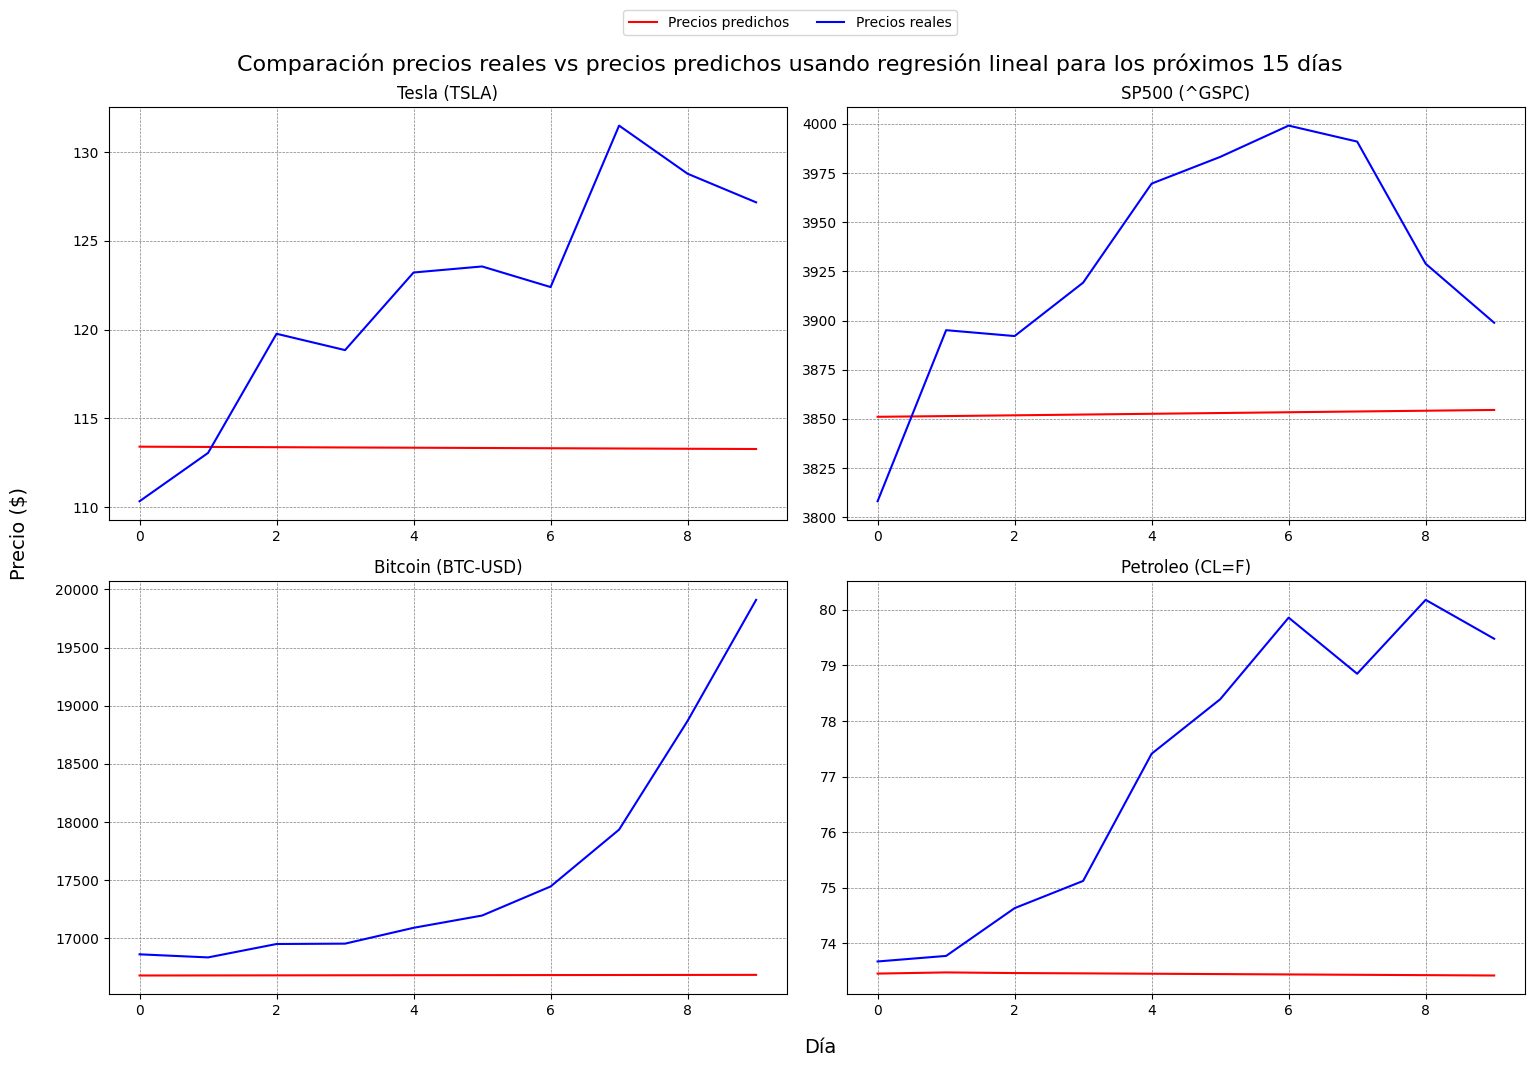

In [32]:
ventana = pasos
dias = 12

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days(datos_tesla_test[0:ventana], ventana, dias, model_lr_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days(datos_sp500_test[0:ventana], ventana, dias, model_lr_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days(datos_bitcoin_test[0:ventana], ventana, dias, model_lr_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days(datos_petroleo_test[0:ventana], ventana, dias, model_lr_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

## SVR

Volvemos a preparar los datos ya que este modelo empelará una ventana diferente:

In [45]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 35
pasos_sp500 = 35
pasos_bitcoin = 50
pasos_petroleo = 20

y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento para Tesla
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)

# Preparar datos de entrenamiento para S&P 500
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)

# Preparar datos de entrenamiento para bitcoin
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)

# Preparar datos de entrenamiento para petróleo
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
x_tesla_t_reg = x_tesla_t.reshape(x_tesla_t.shape[0], -1)

y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
x_sp500_t_reg = x_sp500_t.reshape(x_sp500_t.shape[0], -1)

y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
x_bitcoin_t_reg = x_bitcoin_t.reshape(x_bitcoin_t.shape[0], -1)

y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)
x_petroleo_t_reg = x_petroleo_t.reshape(x_petroleo_t.shape[0], -1)


In [46]:
param_grid = {'C': [1, 10, 100, 200, 300, 500, 600, 800, 1000, 1500, 2000, 3500, 4000, 4500, 10000, 20000, 30000, 40000, 50000, 60000, 61000], 
              'gamma': [1, 0.1, 0.2, 0.4, 0.8, 0.001,0.002,0.004,0.006, 0.0008, 0.000012, 0.000013, 0.000014, 0.000015, 0.000016, 0.000017, 0.000018, 0.000019], 
              'kernel': ['linear', 'rbf']}

model_svr_tesla = SVR()
grid_search = GridSearchCV(model_svr_tesla, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_tesla_reg, np.ravel(y_train_tesla))
model_svr_tesla = grid_search.best_estimator_
best_params_tesla_svr = grid_search.best_params_

print("Mejores parámetros para Tesla: ", grid_search.best_params_)
print("Mejor resultado para Tesla: ", grid_search.best_score_)


model_svr_sp500 = SVR()
grid_search = GridSearchCV(model_svr_sp500, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_sp500_reg, np.ravel(y_train_sp500))
model_svr_sp500 = grid_search.best_estimator_
best_params_sp500_svr = grid_search.best_params_

print("Mejores parámetros para SP500: ", grid_search.best_params_)
print("Mejor resultado para SP500: ", grid_search.best_score_)


model_svr_bitcoin = SVR()
grid_search = GridSearchCV(model_svr_bitcoin, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_bitcoin_reg, np.ravel(y_train_bitcoin))
model_svr_bitcoin = grid_search.best_estimator_
best_params_btc_svr = grid_search.best_params_

print("Mejores parámetros para Bitcoin: ", grid_search.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search.best_score_)


model_svr_petroleo = SVR()
grid_search = GridSearchCV(model_svr_petroleo, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_petroleo_reg, np.ravel(y_train_petroleo))
model_svr_petroleo = grid_search.best_estimator_
best_params_petroleo_svr = grid_search.best_params_

print("Mejores parámetros para Petróleo: ", grid_search.best_params_)
print("Mejor resultado para Petróleo: ", grid_search.best_score_)

Mejores parámetros para Tesla:  {'C': 20000, 'gamma': 1.3e-05, 'kernel': 'rbf'}
Mejor resultado para Tesla:  0.9759853247579251
Mejores parámetros para SP500:  {'C': 600, 'gamma': 1.8e-05, 'kernel': 'rbf'}
Mejor resultado para SP500:  0.9862523265548319
Mejores parámetros para Bitcoin:  {'C': 100, 'gamma': 0.002, 'kernel': 'rbf'}
Mejor resultado para Bitcoin:  0.9710859500418912
Mejores parámetros para Petróleo:  {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Mejor resultado para Petróleo:  0.9647753297574956


Tesla (TSLA)
RMSE:  13.128703927275325
MSE:  172.36286681005456
MAE:  11.363129066891293
R²:  -1.5178799501821048


SP500 (^GSPC)
RMSE:  176.87472679409694
MSE:  31284.668978486432
MAE:  158.07491268692777
R²:  -48.55167471011765


Bitcoin (BTC-USD)
RMSE:  1982.854409525583
MSE:  3931711.6093750484
MAE:  1687.320095206344
R²:  0.413814168120507


Petroleo (CL=F)
RMSE:  3.8722766572621548
MSE:  14.994526510377366
MAE:  3.0840289911720453
R²:  -1.5104024685215327




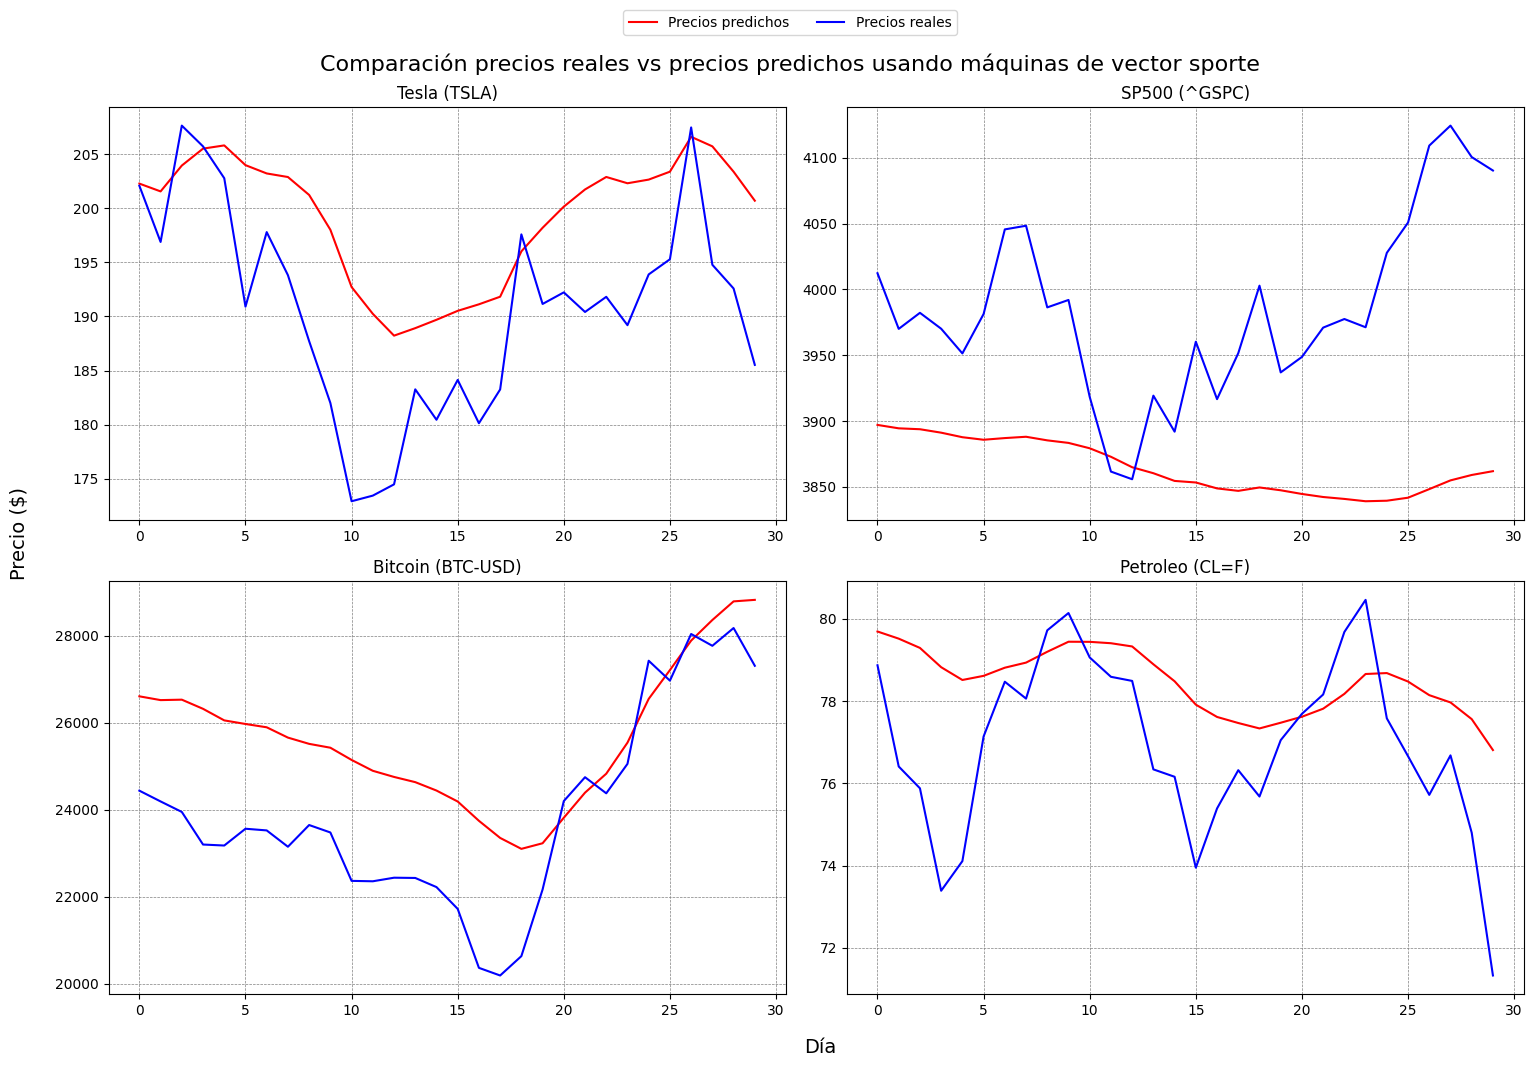

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = model_svr_tesla.predict(x_tesla_t_reg)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = model_svr_sp500.predict(x_sp500_t_reg)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = model_svr_bitcoin.predict(x_bitcoin_t_reg)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = model_svr_petroleo.predict(x_petroleo_t_reg)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando máquinas de vector sporte', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

    El modelo es demasiado simple o no es adecuado para los datos, lo que significa que no es capaz de capturar la complejidad de la relación entre las variables predictoras y la variable objetivo.

    Las características (variables predictoras) que se están utilizando no son relevantes para predecir la variable objetivo.

    La variable objetivo tiene demasiado ruido o variabilidad, lo que hace que sea difícil de predecir.

    El modelo se ha sobreajustado a los datos de entrenamiento y no generaliza bien a nuevos datos.

### Predicción de los siguientes 15 días

Tesla (TSLA)
RMSE:  21.94235115906836
MSE:  481.4667743878686
MAE:  16.218140418782514
R²:  -19.990659087743463


SP500 (^GSPC)
RMSE:  127.05542766272839
MSE:  16143.081698558808
MAE:  118.81305525968617
R²:  -23.08974952728234


Bitcoin (BTC-USD)
RMSE:  5961.868595067203
MSE:  35543877.14484859
MAE:  5604.780904539711
R²:  -14.428424225176439


Petroleo (CL=F)
RMSE:  3.744127180485462
MSE:  14.018488343650015
MAE:  3.308315419189713
R²:  -26.680846598865273




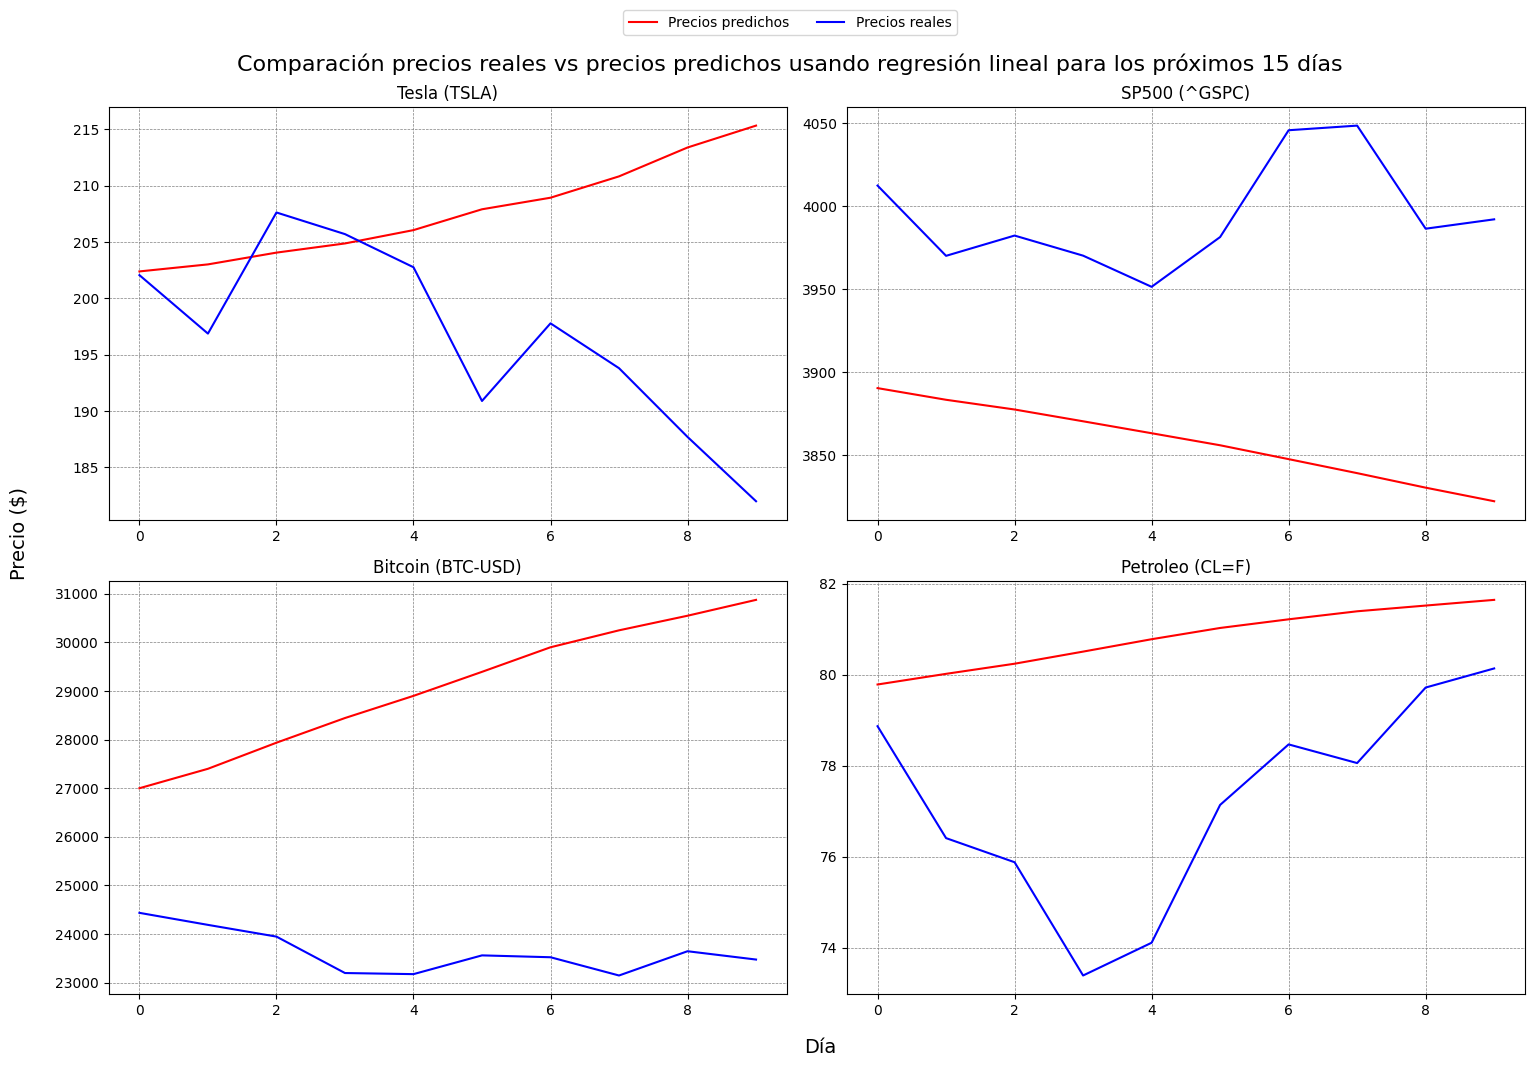

In [48]:
dias = 12

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, model_svr_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, model_svr_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, model_svr_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, model_svr_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

# LSTM

Preparamos los datos de entrenamiento

In [38]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 30
pasos_sp500 = 30
pasos_bitcoin = 30
pasos_petroleo = 30


# Creamos los dataframes
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento 
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

# Preparar datos de Test
y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)


In [39]:
def create_lstm(units, activation):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(None, 1), return_sequences=True))
    model.add(LSTM(units=units, activation=activation, return_sequences=True))
    model.add(LSTM(units=units, activation=activation, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


lstm_tesla = KerasRegressor(build_fn=create_lstm)
lstm_sp500 = KerasRegressor(build_fn=create_lstm)
lstm_bitcoin = KerasRegressor(build_fn=create_lstm)
lstm_petroleo = KerasRegressor(build_fn=create_lstm)

param_grid = {
    'units': [4, 8, 16, 32, 64, 128, 256, 512],
    'activation': ['relu', 'sigmoid']
}

grid_search_tesla = GridSearchCV(estimator=lstm_tesla, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_sp500 = GridSearchCV(estimator=lstm_sp500, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_bitcoin = GridSearchCV(estimator=lstm_bitcoin, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_petroleo = GridSearchCV(estimator=lstm_petroleo, param_grid=param_grid, cv=3, scoring='r2', verbose=0)

grid_search_tesla.fit(x_train_tesla, y_train_tesla)
grid_search_sp500.fit(x_train_sp500, y_train_sp500)
grid_search_bitcoin.fit(x_train_bitcoin, y_train_bitcoin)
grid_search_petroleo.fit(x_train_petroleo, y_train_petroleo)

print("Mejores parámetros para Tesla: ", grid_search_tesla.best_params_)
print("Mejor resultado para Tesla: ", grid_search_tesla.best_score_)

print("Mejores parámetros para SP500: ", grid_search_sp500.best_params_)
print("Mejor resultado para SP500: ", grid_search_sp500.best_score_)

print("Mejores parámetros para Bitcoin: ", grid_search_bitcoin.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search_bitcoin.best_score_)

print("Mejores parámetros para Petróleo: ", grid_search_petroleo.best_params_)
print("Mejor resultado para Petróleo: ", grid_search_petroleo.best_score_)


C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_15664\128357271.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_tesla = KerasRegressor(build_fn=create_lstm)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_15664\128357271.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_sp500 = KerasRegressor(build_fn=create_lstm)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_15664\128357271.py:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_bitcoin = KerasRegressor(build_fn=create_lstm)
C:\Users\Samuel Valer Nast

102/102 [==============================] - 17s 144ms/step - loss: 0.0433
Mejores parámetros para Tesla:  {'activation': 'relu', 'units': 512}
Mejor resultado para Tesla:  0.980036174591241
Mejores parámetros para SP500:  {'activation': 'relu', 'units': 512}
Mejor resultado para SP500:  0.9933979040796358
Mejores parámetros para Bitcoin:  {'activation': 'relu', 'units': 512}
Mejor resultado para Bitcoin:  0.976126004133096
Mejores parámetros para Petróleo:  {'activation': 'relu', 'units': 256}
Mejor resultado para Petróleo:  0.934830690028174


2/2 [==============================] - 0s 33ms/step
Tesla (TSLA)
RMSE:  6.754568082206613
MSE:  45.62418997716433
MAE:  5.141461839862898
R²:  0.7537339988675761


2/2 [==============================] - 0s 30ms/step
SP500 (^GSPC)
RMSE:  38.079309384033685
MSE:  1450.033803164956
MAE:  29.43845262714458
R²:  0.7940362392889942


3/3 [==============================] - 1s 84ms/step
Bitcoin (BTC-USD)
RMSE:  735.7015381606919
MSE:  541256.7532520081
MAE:  510.8495874297753
R²:  0.9399312513269148


2/2 [==============================] - 0s 16ms/step
Petroleo (CL=F)
RMSE:  2.3908851219262166
MSE:  5.71633166624814
MAE:  1.9738995478703403
R²:  0.6732772055985636




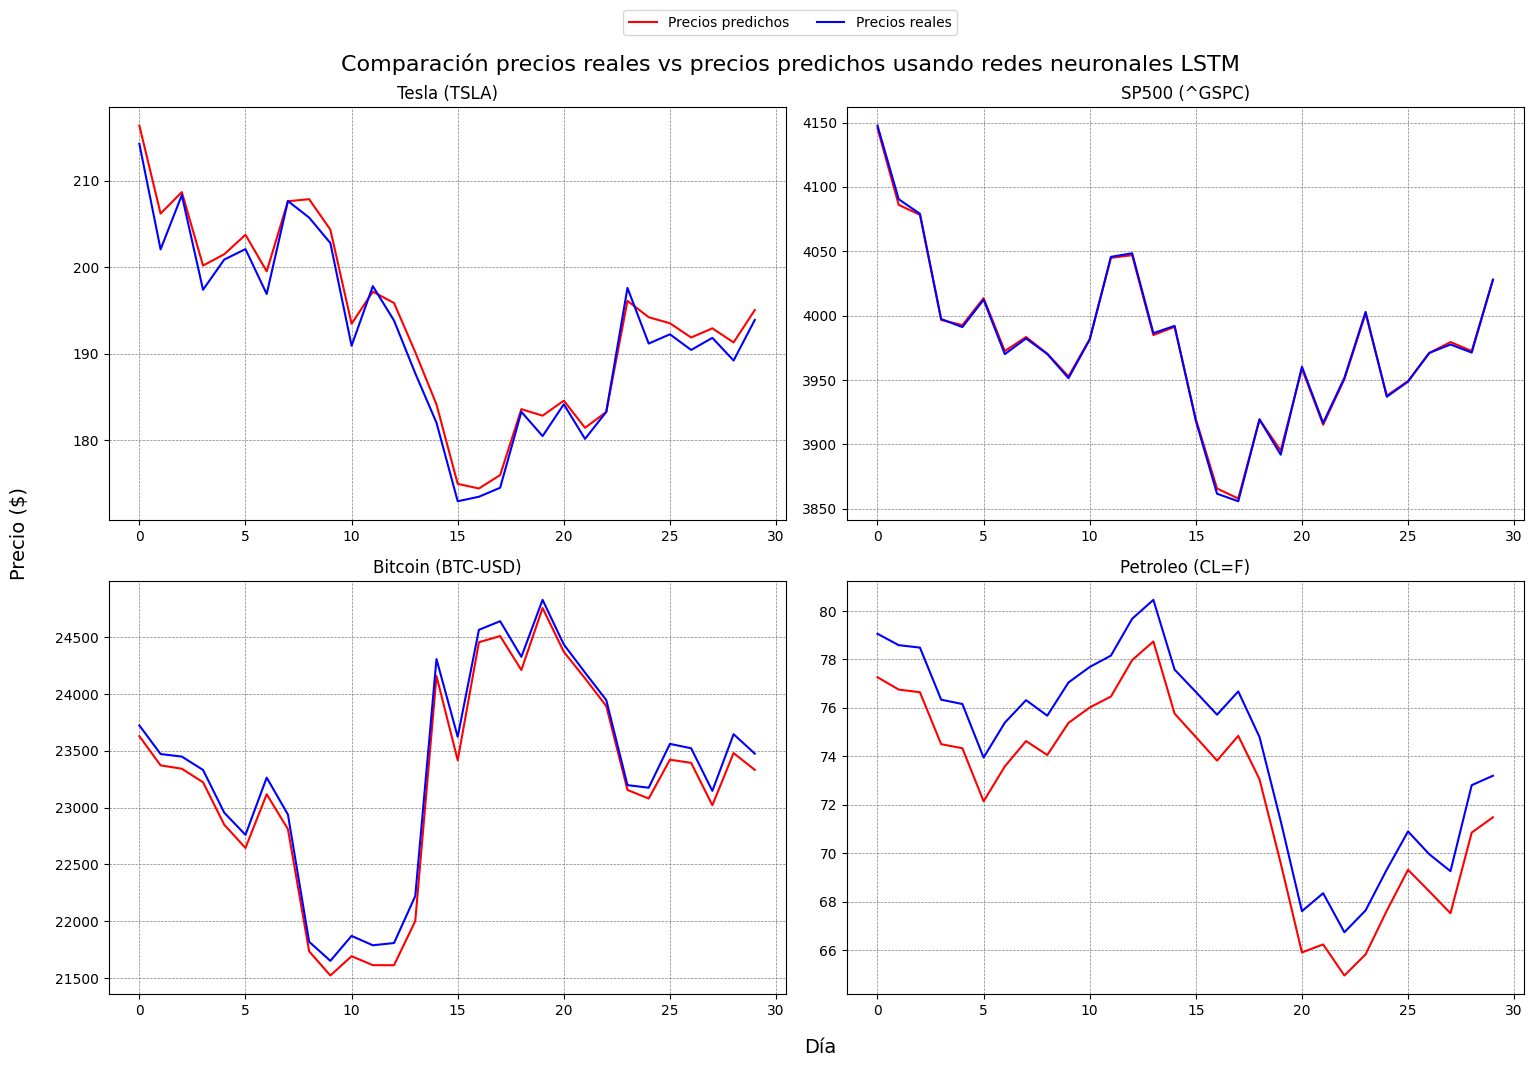

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

lstm_tesla = Sequential()
lstm_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=True))
lstm_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=False))
lstm_tesla.add(Dense(units = 1))

lstm_tesla.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = lstm_tesla.fit(x_train_tesla, y_train_tesla, epochs=200, batch_size=32, verbose = False)
score = lstm_tesla.evaluate(x_tesla_t, y_tesla_t, batch_size=32)
y_pred_tesla_t = lstm_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)
save_model(lstm_tesla, 'lstm_tesla.h5')


lstm_sp500 = Sequential()
lstm_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=True))
lstm_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=False))
lstm_sp500.add(Dense(units = 1))
lstm_sp500.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_sp500.fit(x_train_sp500, y_train_sp500, epochs=200, batch_size=32, verbose = False)
score = lstm_sp500.evaluate(x_sp500_t, y_sp500_t, batch_size=32)
y_pred_sp500_t = lstm_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)
save_model(lstm_sp500, 'lstm_sp500.h5')


lstm_bitcoin = Sequential()
lstm_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=True))
lstm_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=False))
lstm_bitcoin.add(Dense(units = 1))
lstm_bitcoin.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_bitcoin.fit(x_train_bitcoin, y_train_bitcoin, epochs=200, batch_size=32, verbose = False)
score = lstm_bitcoin.evaluate(x_bitcoin_t, y_bitcoin_t, batch_size=32)
y_pred_bitcoin_t = lstm_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)
save_model(lstm_bitcoin, 'lstm_bitcoin.h5')


lstm_petroleo = Sequential()
lstm_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=True))
lstm_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=False))
lstm_petroleo.add(Dense(units = 1))
lstm_petroleo.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_petroleo.fit(x_train_petroleo, y_train_petroleo, epochs=200, batch_size=32, verbose = False)
score = lstm_petroleo.evaluate(x_petroleo_t, y_petroleo_t, batch_size=32)
y_pred_petroleo_t = lstm_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)
save_model(lstm_petroleo, 'lstm_petroleo.h5')


fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

Tesla (TSLA)
RMSE:  13.029897003318904
MSE:  169.77821591709895
MAE:  11.008336385091148
R²:  -2.729394363050414


SP500 (^GSPC)
RMSE:  114.35049789726999
MSE:  13076.03636935355
MAE:  107.35278320312504
R²:  -12.186642987896459


Bitcoin (BTC-USD)
RMSE:  1435.365439946144
MSE:  2060273.9461917877
MAE:  1244.2490234375
R²:  -0.6222134239283788


Petroleo (CL=F)
RMSE:  4.410644641499565
MSE:  19.453786153588826
MAE:  3.962420145670574
R²:  -0.5984133065927728




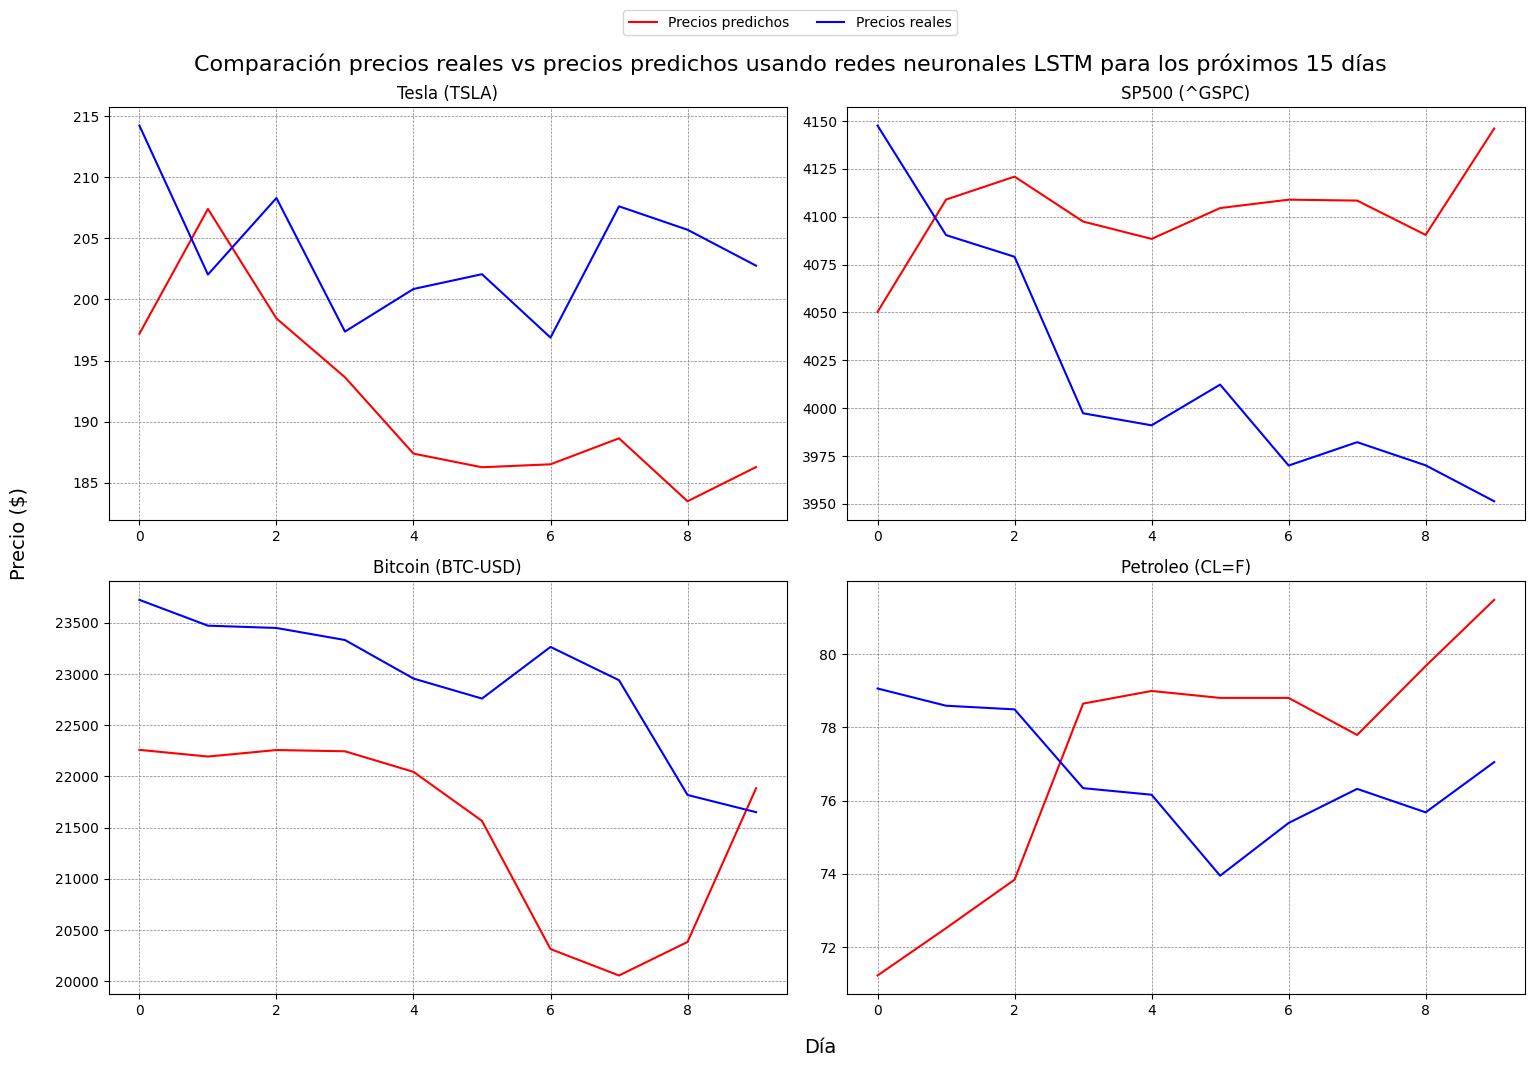

In [41]:
dias = 12

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[pasos_tesla:pasos_tesla*3], pasos_tesla, dias, lstm_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[pasos_sp500:pasos_sp500*3], pasos_sp500, dias, lstm_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[pasos_bitcoin:pasos_bitcoin*3], pasos_bitcoin, dias, lstm_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[pasos_petroleo:pasos_petroleo*3], pasos_petroleo, dias, lstm_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

# GRU

In [42]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 35
pasos_sp500 = 35
pasos_bitcoin = 50
pasos_petroleo = 20


# Creamos los dataframes
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento 
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

# Preparar datos de Test
y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)

In [43]:
def create_gru(units, activation):
    model = Sequential()
    model.add(GRU(units=units, activation=activation, input_shape=(None, 1), return_sequences=True))
    model.add(GRU(units=units, activation=activation, return_sequences=True))
    model.add(GRU(units=units, activation=activation, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

gru_tesla = KerasRegressor(build_fn=create_gru)
gru_sp500 = KerasRegressor(build_fn=create_gru)
gru_bitcoin = KerasRegressor(build_fn=create_gru)
gru_petroleo = KerasRegressor(build_fn=create_gru)

param_grid = {
    'units': [4, 8, 16, 32, 64, 128, 256, 512],
    'activation': ['relu', 'sigmoid']
}

grid_search_tesla = GridSearchCV(estimator=gru_tesla, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_sp500 = GridSearchCV(estimator=gru_sp500, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_bitcoin = GridSearchCV(estimator=gru_bitcoin, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_petroleo = GridSearchCV(estimator=gru_petroleo, param_grid=param_grid, cv=3, scoring='r2', verbose=0)

grid_search_tesla.fit(x_train_tesla, y_train_tesla)
grid_search_sp500.fit(x_train_sp500, y_train_sp500)
grid_search_bitcoin.fit(x_train_bitcoin, y_train_bitcoin)
grid_search_petroleo.fit(x_train_petroleo, y_train_petroleo)

print("Mejores parámetros para Tesla: ", grid_search_tesla.best_params_)
print("Mejor resultado para Tesla: ", grid_search_tesla.best_score_)

print("Mejores parámetros para SP500: ", grid_search_sp500.best_params_)
print("Mejor resultado para SP500: ", grid_search_sp500.best_score_)

print("Mejores parámetros para Bitcoin: ", grid_search_bitcoin.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search_bitcoin.best_score_)

print("Mejores parámetros para Petróleo: ", grid_search_petroleo.best_params_)
print("Mejor resultado para Petróleo: ", grid_search_petroleo.best_score_)


C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_15664\2670767980.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  gru_tesla = KerasRegressor(build_fn=create_gru)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_15664\2670767980.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  gru_sp500 = KerasRegressor(build_fn=create_gru)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_15664\2670767980.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  gru_bitcoin = KerasRegressor(build_fn=create_gru)
C:\Users\Samuel Valer Nasta\A

102/102 [==============================] - 17s 141ms/step - loss: 0.0152
Mejores parámetros para Tesla:  {'activation': 'relu', 'units': 256}
Mejor resultado para Tesla:  0.9903993573313731
Mejores parámetros para SP500:  {'activation': 'relu', 'units': 512}
Mejor resultado para SP500:  0.9974789064105206
Mejores parámetros para Bitcoin:  {'activation': 'relu', 'units': 128}
Mejor resultado para Bitcoin:  0.9901768840103911
Mejores parámetros para Petróleo:  {'activation': 'relu', 'units': 512}
Mejor resultado para Petróleo:  0.967509563693147


KeyboardInterrupt: 

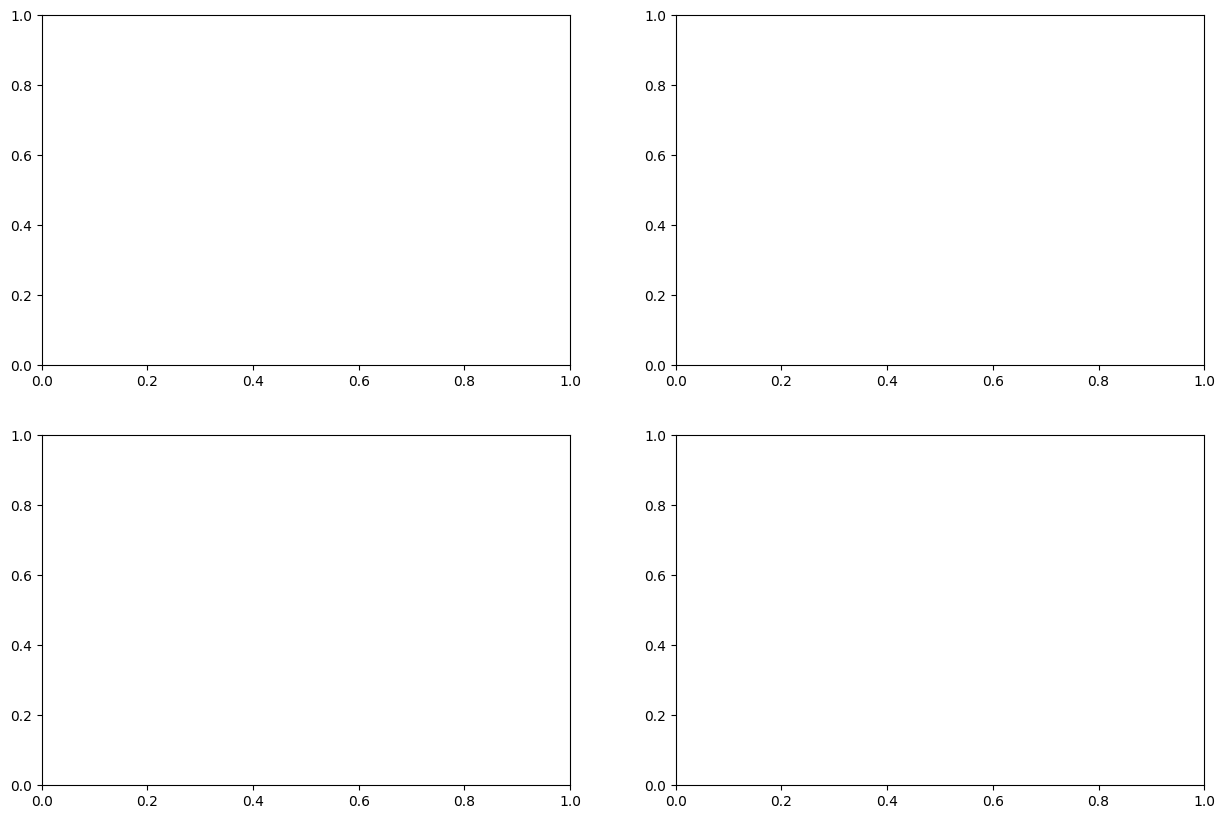

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

gru_tesla = Sequential()
gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=True))
gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=False))
gru_tesla.add(Dense(units = 1))

gru_tesla.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = gru_tesla.fit(x_train_tesla, y_train_tesla, epochs=200, batch_size=32, verbose = False)
score = gru_tesla.evaluate(x_tesla_t, y_tesla_t, batch_size=32)
y_pred_tesla_t = gru_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)
save_model(gru_tesla, 'gru_tesla.h5')



gru_sp500 = Sequential()
gru_sp500.add(GRU(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], input_shape = (None, 1), return_sequences=False))
gru_sp500.add(GRU(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=True))
gru_sp500.add(GRU(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=False))
gru_sp500.add(Dense(units = 1))
gru_sp500.compile(optimizer='adam', loss='mean_squared_error')
history = gru_sp500.fit(x_train_sp500, y_train_sp500, epochs=200, batch_size=32, verbose = False)
score = gru_sp500.evaluate(x_sp500_t, y_sp500_t, batch_size=32)
y_pred_sp500_t = gru_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)
save_model(gru_sp500, 'gru_sp500.h5')


gru_bitcoin = Sequential()
gru_bitcoin.add(GRU(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], input_shape = (None, 1), return_sequences=False))
gru_bitcoin.add(GRU(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=True))
gru_bitcoin.add(GRU(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=False))
gru_bitcoin.add(Dense(units = 1))
gru_bitcoin.compile(optimizer='adam', loss='mean_squared_error')
history = gru_bitcoin.fit(x_train_bitcoin, y_train_bitcoin, epochs=200, batch_size=32, verbose = False)
score = gru_bitcoin.evaluate(x_bitcoin_t, y_bitcoin_t, batch_size=32)
y_pred_bitcoin_t = gru_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)
save_model(gru_bitcoin, 'gru_bitcoin.h5')

gru_petroleo = Sequential()
gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], input_shape = (None, 1), return_sequences=False))
gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=True))
gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=False))
gru_petroleo.add(Dense(units = 1))
gru_petroleo.compile(optimizer='adam', loss='mean_squared_error')
history = gru_petroleo.fit(x_train_petroleo, y_train_petroleo, epochs=200, batch_size=32, verbose = False)
score = gru_petroleo.evaluate(x_petroleo_t, y_petroleo_t, batch_size=32)
y_pred_petroleo_t = gru_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)
save_model(gru_petroleo, 'gru_petroleo.h5')

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales GRU', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

Tesla (TSLA)
RMSE:  7.6412706131676105
MSE:  58.38901658365891
MAE:  6.310476938883461
R²:  -0.5947399679528587


SP500 (^GSPC)
RMSE:  6849.576843287888
MSE:  46916702.93210566
MAE:  5587.944478352864
R²:  -2.0277070028660975


Bitcoin (BTC-USD)
RMSE:  16654.786737882045
MSE:  277381921.2843316
MAE:  14323.0517578125
R²:  -3.331934370934425


Petroleo (CL=F)
RMSE:  5.9854540143551604
MSE:  35.8256597579603
MAE:  5.549924850463871
R²:  -4.152528672804978




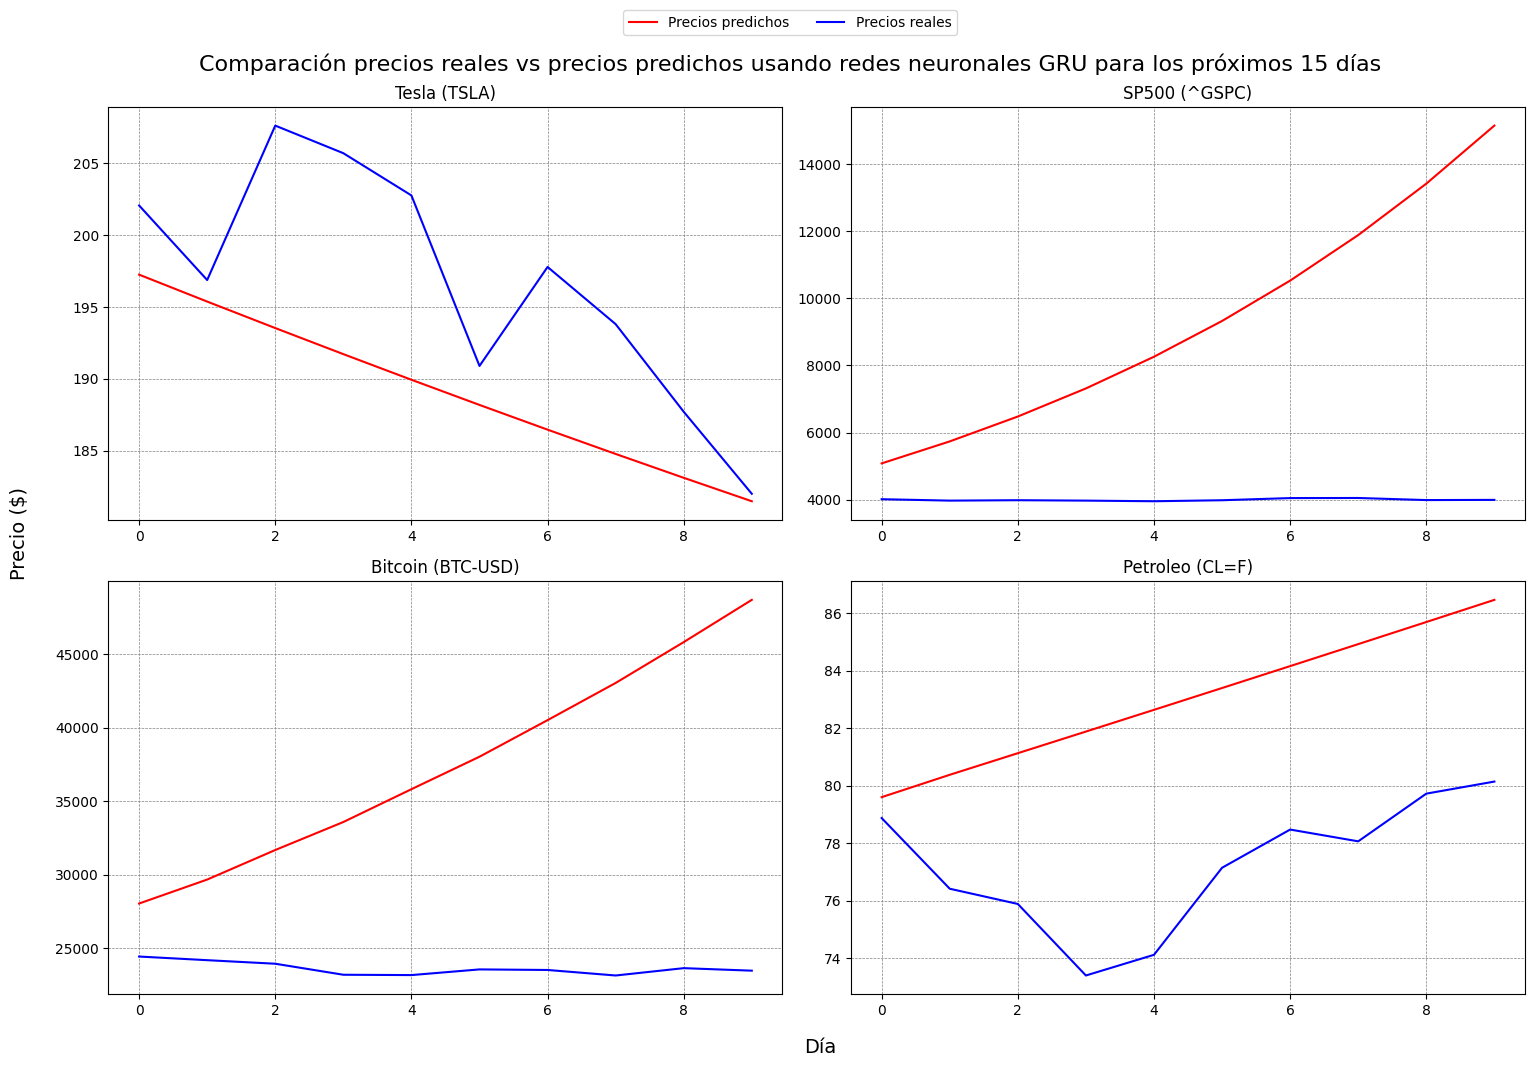

In [ ]:
dias = 12

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, gru_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, gru_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, gru_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, gru_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales GRU para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

# LSTM + GRU

In [ ]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 30
pasos_sp500 = 30
pasos_bitcoin = 30
pasos_petroleo = 30

# Creamos los dataframes
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento 
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

# Preparar datos de Test
y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)


In [ ]:
def create_lstm_gru(units, activation):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(None, 1), return_sequences=True))
    model.add(LSTM(units=units, activation=activation, return_sequences=True))
    model.add(GRU(units=units, activation=activation, return_sequences=True))
    model.add(GRU(units=units, activation=activation, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


lstm_gru_tesla = KerasRegressor(build_fn=create_lstm_gru)
lstm_gru_sp500 = KerasRegressor(build_fn=create_lstm_gru)
lstm_gru_bitcoin = KerasRegressor(build_fn=create_lstm_gru)
lstm_gru_petroleo = KerasRegressor(build_fn=create_lstm_gru)

param_grid = {
    'units': [4, 8, 16, 32, 64, 128, 256, 512],
    'activation': ['relu', 'sigmoid']
}

grid_search_tesla = GridSearchCV(estimator=lstm_gru_tesla, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search_sp500 = GridSearchCV(estimator=lstm_gru_sp500, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search_bitcoin = GridSearchCV(estimator=lstm_gru_bitcoin, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search_petroleo = GridSearchCV(estimator=lstm_gru_petroleo, param_grid=param_grid, cv=3, scoring='r2', verbose=1)

grid_search_tesla.fit(x_train_tesla, y_train_tesla)
grid_search_sp500.fit(x_train_sp500, y_train_sp500)
grid_search_bitcoin.fit(x_train_bitcoin, y_train_bitcoin)
grid_search_petroleo.fit(x_train_petroleo, y_train_petroleo)

print("Mejores parámetros para Tesla: ", grid_search_tesla.best_params_)
print("Mejor resultado para Tesla: ", grid_search_tesla.best_score_)

print("Mejores parámetros para SP500: ", grid_search_sp500.best_params_)
print("Mejor resultado para SP500: ", grid_search_sp500.best_score_)

print("Mejores parámetros para Bitcoin: ", grid_search_bitcoin.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search_bitcoin.best_score_)

print("Mejores parámetros para Petróleo: ", grid_search_petroleo.best_params_)
print("Mejor resultado para Petróleo: ", grid_search_petroleo.best_score_)


C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_37548\2556034535.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_gru_tesla = KerasRegressor(build_fn=create_lstm_gru)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_37548\2556034535.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_gru_sp500 = KerasRegressor(build_fn=create_lstm_gru)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_37548\2556034535.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_gru_bitcoin = KerasRegressor(build_fn=create_lstm_gru)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
98/98 [==============================] - 22s 203ms/step - loss: 0.0026
Fitting 3 folds for each of 16 candidates, totalling 48 fits
102/102 [==============================] - 9s 69ms/step - loss: 0.0102
Fitting 3 folds for each of 16 candidates, totalling 48 fits
94/94 [==============================] - 8s 69ms/step - loss: 0.0058
Fitting 3 folds for each of 16 candidates, totalling 48 fits
102/102 [==============================] - 19s 169ms/step - loss: 0.0205
Mejores parámetros para Tesla:  {'activation': 'relu', 'units': 512}
Mejor resultado para Tesla:  0.990141075681071
Mejores parámetros para SP500:  {'activation': 'relu', 'units': 256}
Mejor resultado para SP500:  0.9961383001503226
Mejores parámetros para Bitcoin:  {'activation': 'relu', 'units': 256}
Mejor resultado para Bitcoin:  0.9869352535806973
Mejores parámetros para Petróleo:  {'activation': 'relu', 'units': 512}
Mejor resultado para Petróleo:  0.970958752776

function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,60000)

3/3 [==============================] - 0s 3ms/step
Tesla (TSLA)
RMSE:  13.771611723781643
MSE:  189.6572894706
MAE:  12.115571572747026
R²:  0.32726852568697984


3/3 [==============================] - 0s 4ms/step
SP500 (^GSPC)
RMSE:  2712.2272534171843
MSE:  7356176.674178923
MAE:  2711.507159165933
R²:  -7025.008170108131


4/4 [==============================] - 0s 5ms/step
Bitcoin (BTC-USD)
RMSE:  13122.488121512475
MSE:  172199694.499236
MAE:  12061.944989965596
R²:  -5.578349295387787


3/3 [==============================] - 0s 11ms/step
Petroleo (CL=F)
RMSE:  2.076103977523091
MSE:  4.310207725487199
MAE:  1.6245141559176988
R²:  0.7122989034897063




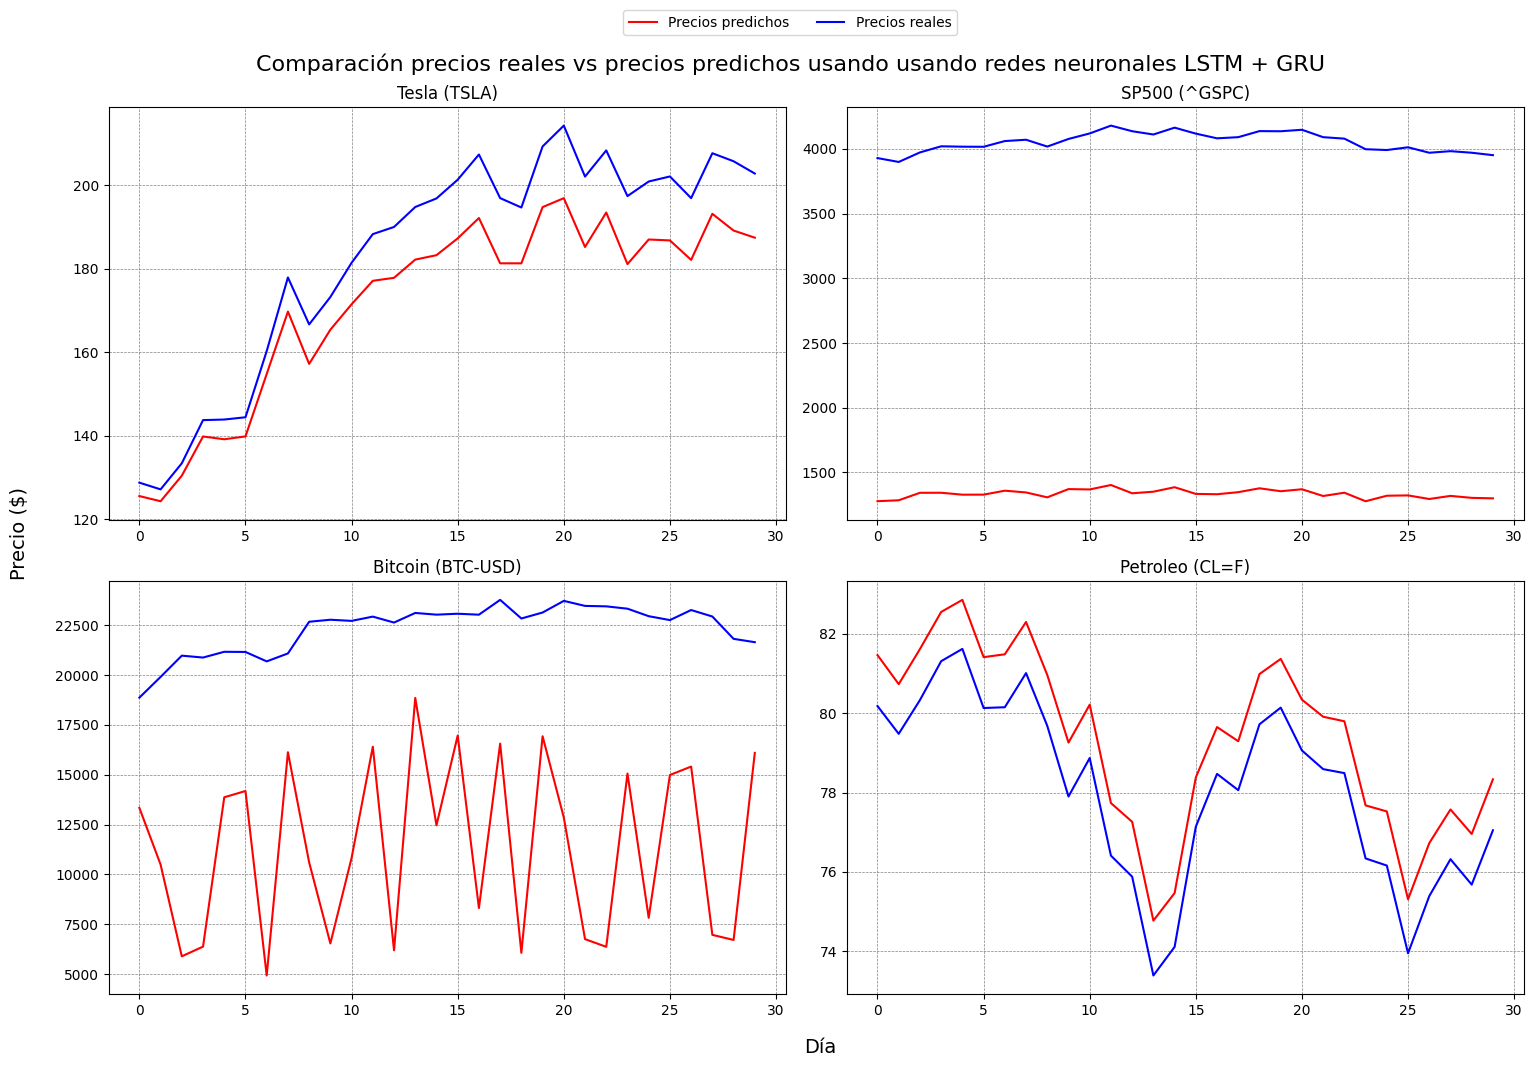

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

lstm_gru_tesla = Sequential()
lstm_gru_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_gru_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=True))
lstm_gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=True))
lstm_gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=False))
lstm_gru_tesla.add(Dense(units = 1))

lstm_gru_tesla.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = lstm_gru_tesla.fit(x_train_tesla, y_train_tesla, epochs=200, batch_size=32, verbose = False)
score = lstm_gru_tesla.evaluate(x_tesla_t, y_tesla_t, batch_size=32)
y_pred_tesla_t = lstm_gru_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)
save_model(lstm_gru_tesla, 'lstm_gru_tesla.h5')

lstm_gru_sp500 = Sequential()
lstm_gru_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_gru_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=True))
lstm_gru_sp500.add(GRU(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=True))
lstm_gru_sp500.add(GRU(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=False))
lstm_gru_sp500.add(Dense(units = 1))
lstm_gru_sp500.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_gru_sp500.fit(x_train_sp500, y_train_sp500, epochs=200, batch_size=32, verbose = False)
score = lstm_gru_sp500.evaluate(x_sp500_t, y_sp500_t, batch_size=32)
y_pred_sp500_t = lstm_gru_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)
save_model(lstm_gru_sp500, 'lstm_gru_sp500.h5')

lstm_gru_bitcoin = Sequential()
lstm_gru_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_gru_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=True))
lstm_gru_bitcoin.add(GRU(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=True))
lstm_gru_bitcoin.add(GRU(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=False))
lstm_gru_bitcoin.add(Dense(units = 1))
lstm_gru_bitcoin.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_gru_bitcoin.fit(x_train_bitcoin, y_train_bitcoin, epochs=200, batch_size=32, verbose = False)
score = lstm_gru_bitcoin.evaluate(x_bitcoin_t, y_bitcoin_t, batch_size=32)
y_pred_bitcoin_t = lstm_gru_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)
save_model(lstm_gru_bitcoin, 'lstm_gru_bitcoin.h5')


lstm_gru_petroleo = Sequential()
lstm_gru_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_gru_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=True))
lstm_gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=True))
lstm_gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=False))
lstm_gru_petroleo.add(Dense(units = 1))
lstm_gru_petroleo.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_gru_petroleo.fit(x_train_petroleo, y_train_petroleo, epochs=200, batch_size=32, verbose = False)
score = lstm_gru_petroleo.evaluate(x_petroleo_t, y_petroleo_t, batch_size=32)
y_pred_petroleo_t = lstm_gru_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)
save_model(lstm_gru_petroleo, 'lstm_gru_petroleo.h5')


fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando usando redes neuronales LSTM + GRU', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

Tesla (TSLA)
RMSE:  48.340700681902355
MSE:  2336.8233424172745
MAE:  39.82572237650553
R²:  -45.95084333518534


SP500 (^GSPC)
RMSE:  8603.459830057065
MSE:  74019521.04740554
MAE:  8371.844156901041
R²:  -18.396489635111323


Bitcoin (BTC-USD)
RMSE:  22267.87340701888
MSE:  495858186.07101864
MAE:  22062.64441172282
R²:  -71.75394418910031


Petroleo (CL=F)
RMSE:  8.655496793548403
MSE:  74.9176247431267
MAE:  7.005244572957362
R²:  -3.44946551931666




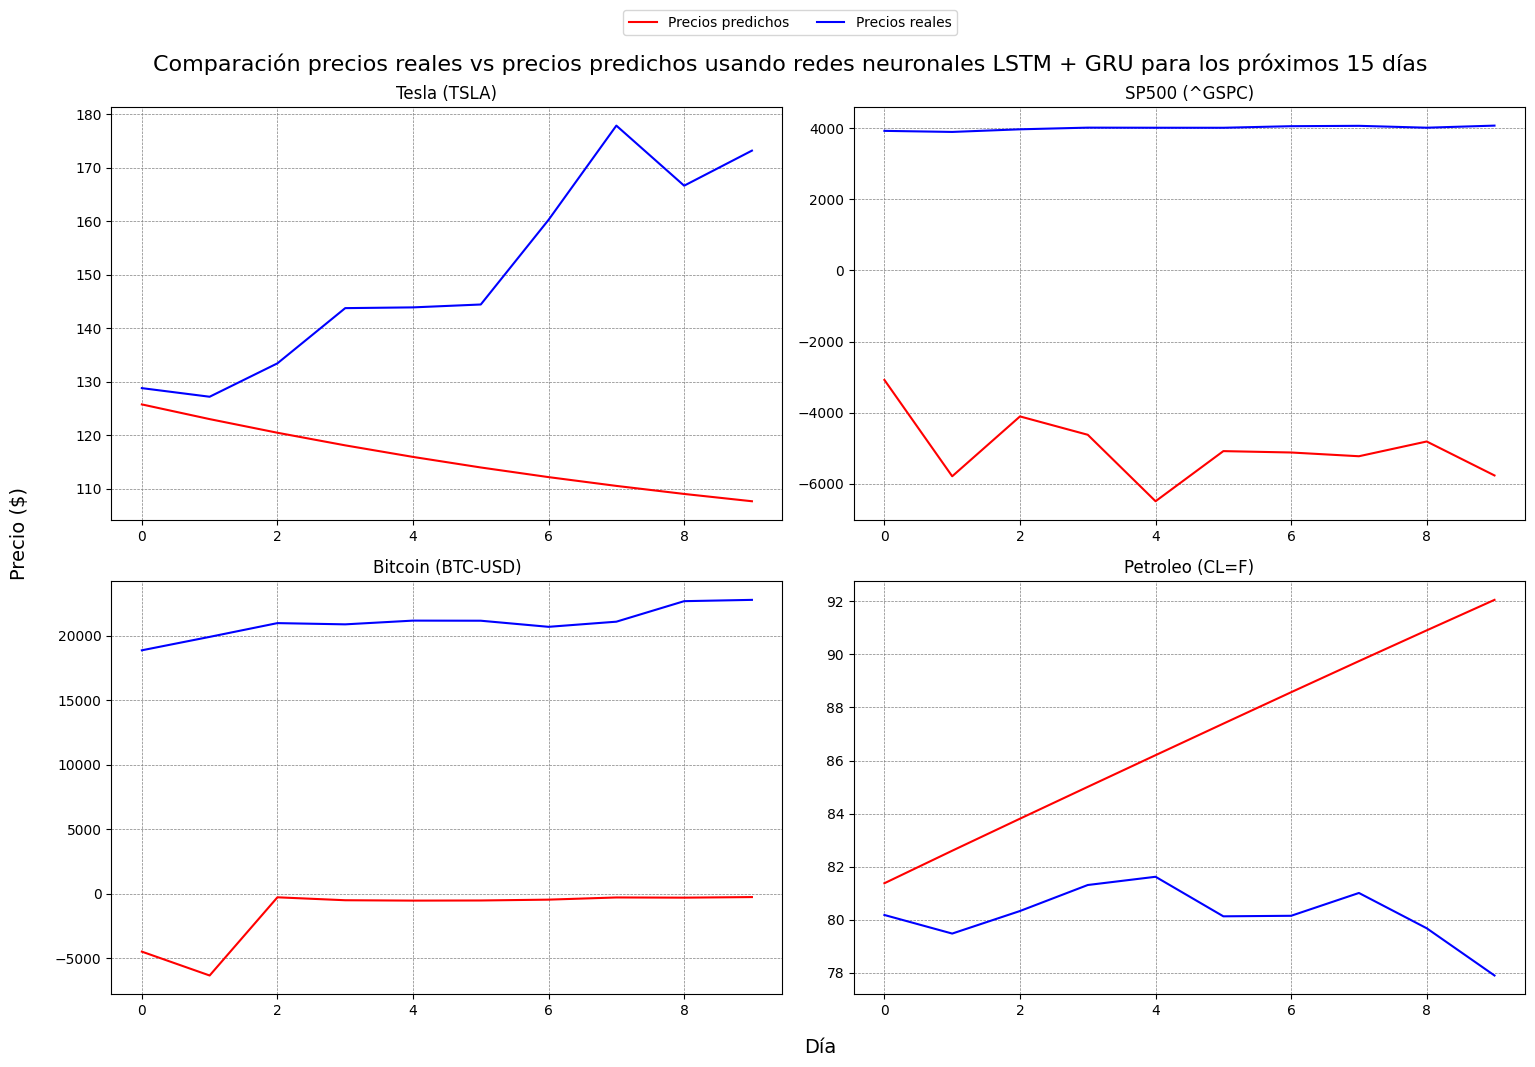

In [ ]:
dias = 12

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, lstm_gru_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, lstm_gru_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, lstm_gru_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, lstm_gru_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM + GRU para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()